In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.stats import pearsonr, spearmanr
plt.style.use('../images/presentation.mplstyle')
plt.rcParams["figure.figsize"] = (12, 6)
import scipy as sc
from scipy.interpolate import interp1d
import seaborn as sns
import copy
import pickle

In [2]:
def get_cmap(n=20, map_str= 'hsv'):
    cmap = plt.get_cmap(map_str)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    return colors

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
with open('impact_factor_dict.pickle', 'rb') as handle:
    import_factor_dict = pickle.load(handle)

In [5]:
people_per_age = pd.read_csv("num_people_per_age.csv")

In [6]:
geo_stats = pd.read_csv("geographic-sum-per-day-ver_00141.csv")
# geo_stats_2 = pd.read_csv("corona_city_table_ver_0076.csv")
# geo_vacc_per_age = pd.read_csv("vaccinated_city_table_ver_0031.csv")


# recover_data = pd.read_excel("corona_recovered_ver_00120.xlsx")
# hospital_data = pd.read_csv("corona_hospitalization_ver_00231.csv")
# dead_data = pd.read_csv("corona_deceased_ver_0095.csv")

# age_gender_test_data = pd.read_csv("corona_age_and_gender_ver_0092.csv")
# young_test_data = pd.read_excel("young_population_weekly_ver_0037.xlsx")

In [7]:
geo_vacc_per_age = pd.read_csv("vaccinated_city_table_ver_0031.csv")

In [8]:
geo_vacc_per_age = geo_vacc_per_age.replace(to_replace={'<15': 4})
geo_vacc_per_age['Date'] = pd.to_datetime(geo_vacc_per_age['Date'],format='%Y-%m-%d')
geo_vacc_per_age = geo_vacc_per_age.rename(columns={'Date':'date'})

In [9]:
float_columns = ['first_dose_0-19', 'first_dose_20-29', 'first_dose_30-39', 'first_dose_40-49', 
                 'first_dose_50-59', 'first_dose_60-69', 'first_dose_70-79', 'first_dose_80-89', 'first_dose_90+', 
                 'second_dose_0-19', 'second_dose_20-29', 'second_dose_30-39', 'second_dose_40-49', 'second_dose_50-59',
                 'second_dose_60-69', 'second_dose_70-79', 'second_dose_80-89', 'second_dose_90+']
geo_vacc_per_age[float_columns] = geo_vacc_per_age[float_columns].astype(float)

In [10]:
def get_percentage_people_per_age_group(people_per_age, ages):
    n_total = people_per_age.num_people.sum()
    percentage_per_age = {}
    for a in ages:
        n_people = people_per_age[(people_per_age.age>=a[0]) & (people_per_age.age<=a[1])].num_people.sum()
        percentage = 100 * n_people/n_total
        percentage_per_age[a] = percentage
    return percentage_per_age

In [11]:
ages_impact_factor = [(int(a.split('-')[0]), int(a.split('-')[1])) for a in list(import_factor_dict.keys())]
ages_impact_factor.append((9, 19))
ages_impact_factor.append((20, 29))
ages_impact_factor.append((30, 39))
ages_impact_factor.append((40, 49))
ages_impact_factor.append((50, 59))
ages_impact_factor.append((60, 69))
ages_impact_factor.append((70, 79))
ages_impact_factor.append((80, 100))
percentages_each_age = get_percentage_people_per_age_group(people_per_age, ages_impact_factor)

In [12]:
impact_factor_per_age = { '10-19': (import_factor_dict['9-11'] * percentages_each_age[(9, 11)] + 
                                    import_factor_dict['12-14'] * percentages_each_age[(12, 14)] + 
                                    import_factor_dict['15-17'] * percentages_each_age[(15, 17)] + 
                                    import_factor_dict['18-20'] * percentages_each_age[(18, 20)])/ percentages_each_age[(9, 19)],  
 '20-29': (import_factor_dict['20-24'] * percentages_each_age[(20, 24)] +  
           import_factor_dict['25-29'] * percentages_each_age[(25, 29)])/ percentages_each_age[(20, 29)],  
 '30-39': (import_factor_dict['30-34'] * percentages_each_age[(30, 34)] +  
           import_factor_dict['35-39'] * percentages_each_age[(35, 39)])/ percentages_each_age[(30, 39)], 
 '40-49': (import_factor_dict['40-44'] * percentages_each_age[(40, 44)] +  
           import_factor_dict['45-49'] * percentages_each_age[(45, 49)])/ percentages_each_age[(40, 49)],  
 '50-59': (import_factor_dict['50-54'] * percentages_each_age[(50, 54)] +  
           import_factor_dict['55-59'] * percentages_each_age[(55, 59)])/ percentages_each_age[(50, 59)], 
 '60-69': (import_factor_dict['60-64'] * percentages_each_age[(60, 64)] +  
           import_factor_dict['65-69'] * percentages_each_age[(65, 69)])/ percentages_each_age[(60, 69)],
 '70-79': (import_factor_dict['70-74'] * percentages_each_age[(70, 74)] +  
           import_factor_dict['75-79'] * percentages_each_age[(75, 79)])/ percentages_each_age[(70, 79)], 
 '80+': import_factor_dict['80-100']}

In [13]:
impact_factor_per_age

{'10-19': 1.2107535794348698,
 '20-29': 1.4001970064474196,
 '30-39': 1.1207304563836042,
 '40-49': 1.1001582026192167,
 '50-59': 1.09831020696158,
 '60-69': 0.833038772069703,
 '70-79': 0.6630477062073574,
 '80+': 0.776791481986468}

In [14]:
mean_age_for_impact_factor = np.array([(int(a.split('-')[0]), int(a.split('-')[1])) for a in list(import_factor_dict.keys())]).mean(axis=1)
impact_factor_for_interp = np.array(list(import_factor_dict.values()))

In [15]:
f_impact = interp1d(mean_age_for_impact_factor, impact_factor_for_interp)

In [16]:
def create_vacc_efficiency_per_city(data_in, city):
    data = data_in.copy()
    infect_dec=np.zeros((108))
    infect_dec[:14]=1
    infect_dec[14:21]=0.43
    infect_dec[21:27]=0.34
    infect_dec[27:]=0.06
    infect_dec = 1 - infect_dec
    columns=['date', '10-19',  '20-29',  '30-39', '40-49',  '50-59',  '60-69',  '70-79', '80-89', '99-100']
    data_per_city = data[data.CityName == city]
    columns_real=data_per_city.columns
    matrix_values=data_per_city.values
    matrix_values[1:,3:]-=matrix_values[:-1,3:]
    agg_vacc_data = pd.DataFrame(matrix_values, columns =columns_real)
    float_columns = ['first_dose_0-19', 'first_dose_20-29', 'first_dose_30-39', 'first_dose_40-49', 
                     'first_dose_50-59', 'first_dose_60-69', 'first_dose_70-79', 'first_dose_80-89', 'first_dose_90+', 
                     'second_dose_0-19', 'second_dose_20-29', 'second_dose_30-39', 'second_dose_40-49', 'second_dose_50-59',
                 'second_dose_60-69', 'second_dose_70-79', 'second_dose_80-89', 'second_dose_90+']
    agg_vacc_data[float_columns] = agg_vacc_data[float_columns].astype(float)
    matrix_values=copy.deepcopy(agg_vacc_data.values[:,2:12])
    matrix_values_2=copy.deepcopy(agg_vacc_data.values[:,2:12])
    for i in range(matrix_values.shape[0]):
        matrix_values_2[i,1:]=np.dot(np.expand_dims(infect_dec[:i+1][::-1],axis=0),matrix_values[:i+1,1:])
    all_vacc_data = pd.DataFrame(matrix_values_2, columns =columns)
    float_columns = ['10-19',  '20-29',  '30-39', '40-49',  '50-59',  '60-69',  '70-79', '80-89', '99-100']
    all_vacc_data[float_columns] = all_vacc_data[float_columns].astype(int)
    all_vacc_data['80+'] = all_vacc_data.iloc[:, -2:].sum(axis=1)
    all_vacc_data = all_vacc_data.drop(columns=['80-89', '99-100'])
    all_vacc_data['weeks_from'] = np.round((all_vacc_data['date'] - pd.to_datetime('2020-03-21',format='%Y-%m-%d')).dt.days / 7, 1).astype(int)
    return all_vacc_data

In [17]:
def get_num_vaccinations_per_week_per_city_with_age_factors(vacc_data_per_age, impact_factor):
    temp_df = copy.deepcopy(vacc_data_per_age)
    temp_df.iloc()[: ,1:-1] = vacc_data_per_age.iloc()[:, 1:-1] * np.array(list(impact_factor_per_age.values()))
    temp_df['num_accumulated_vacc'] = temp_df.iloc()[:, 1:-1].sum(axis=1)
    data_vacc_impact_columns = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79',
       '80+', 'num_accumulated_vacc']
    agg_dict = {k:'last' for k in data_vacc_impact_columns}
    temp_df = temp_df.groupby("weeks_from", as_index=False).agg(agg_dict)
    return temp_df

In [18]:
israel_population = pd.read_excel("israel_population_by_city.xlsx")
israel_population_with_ages = pd.read_excel("israel_total_population_by_age.xlsx")
israel_english_names = pd.read_excel("israel_town_code_name_english.xlsx")
median_israeli_population = pd.read_excel("median_israeli_population.xlsx")

## organize geographic data 

In [19]:
geo_stats = pd.read_csv("geographic-sum-per-day-ver_00141.csv")
geo_stats['date'] = pd.to_datetime(geo_stats['date'],format='%Y-%m-%d')

In [20]:
geo_stats['weeks_from'] = np.round((geo_stats['date'] - pd.to_datetime('2020-03-21',format='%Y-%m-%d')).dt.days / 7, 1).astype(int)
geo_stats = geo_stats[geo_stats.weeks_from >= 0]

In [21]:
geo_stats = geo_stats.replace(to_replace={'<15': 4})

In [22]:
geo_float_columns = ['accumulated_cases', 'accumulated_recoveries', 
       'accumulated_hospitalized', 
       'accumulated_deaths', 
       'accumulated_diagnostic_tests', 
       'accumulated_vaccination_first_dose', 
       'accumulated_vaccination_second_dose']
geo_stats[geo_float_columns] = geo_stats[geo_float_columns].astype(float)

In [23]:
# create recoveries from accumulated + 10 days, assuming people are not contagious after 10 days
geo_recoveries = geo_stats[['town_code', 'agas_code', 'town', 'date', 'accumulated_cases']].copy()
new_dates = geo_recoveries['date'] + pd.DateOffset(days=10)
geo_recoveries['date'] = new_dates
geo_recoveries = geo_recoveries.rename(columns={'accumulated_cases': 'accumulated_recoveries_fixed'})

In [24]:
geo_stats = pd.merge(geo_stats, geo_recoveries, how='left', on=['town_code', 'agas_code', 'town', 'date'])

In [25]:
geo_stats['accumulated_recoveries_fixed'] =  geo_stats['accumulated_recoveries_fixed'].fillna(0)

In [26]:
weeks_dict_agas = {'weeks_from': 'first',
                   'town_code': 'first',
              'town': 'first', 
              'date': 'first', 
              'accumulated_cases': 'sum',
              'accumulated_recoveries': 'sum', 
              'accumulated_hospitalized': 'sum', 
              'accumulated_deaths': 'sum',
              'accumulated_diagnostic_tests': 'sum',
              'accumulated_vaccination_first_dose':'sum',
              'accumulated_vaccination_second_dose': 'sum',
              'accumulated_recoveries_fixed': 'sum'}
weeks_dict = {
              'town_code': 'first',
              'town': 'first', 
              'date': 'last', 
              'accumulated_cases': 'last',
              'accumulated_recoveries': 'last', 
              'accumulated_hospitalized': 'last', 
              'accumulated_deaths': 'last',
              'accumulated_diagnostic_tests': 'last',
              'accumulated_vaccination_first_dose':'last',
              'accumulated_vaccination_second_dose': 'last',
              'accumulated_recoveries_fixed': 'last'}
geo_stats = geo_stats.groupby(['town_code', 'date'], as_index=False).agg(weeks_dict_agas)
geo_stats = geo_stats.groupby(['weeks_from', 'town_code'], as_index=False).agg(weeks_dict)

In [27]:
israel_english_names = israel_english_names.rename(columns={'town':'city'})

In [28]:
israel_population = israel_population.rename(columns={'city_code':'town_code', 'city': 'town'})

In [29]:
median_israeli_population = median_israeli_population.rename(columns={'city_code':'town_code'})

In [30]:
median_israeli_population = median_israeli_population.drop(columns=['city', 'population_size','city_english'])

In [31]:
geo_stats = pd.merge(median_israeli_population, geo_stats, how='right', on='town_code')

In [32]:
geo_stats = pd.merge(israel_population, geo_stats, how='right', on=['town_code'])

In [33]:
geo_stats = pd.merge(israel_english_names, geo_stats, how='right', on='town_code')

In [34]:
geo_float_columns.append("accumulated_recoveries_fixed")
percentage_dict = {f'percentage_{w}' : 100 * geo_stats[w] / geo_stats['num_population'] for w in geo_float_columns}
percentage_dict['weeks_from'] = geo_stats.weeks_from
percentage_dict['town_code'] = geo_stats.town_code
percentage_df = pd.DataFrame(percentage_dict)

In [35]:
geo_stats = pd.merge(geo_stats, percentage_df, on=['weeks_from', 'town_code'], how='inner')

In [36]:
geo_stats['percentage_accumulated_immuned'] = geo_stats.percentage_accumulated_recoveries_fixed + geo_stats.percentage_accumulated_vaccination_second_dose
geo_stats['accumulated_immuned'] = geo_stats.accumulated_recoveries_fixed + geo_stats.accumulated_vaccination_second_dose

In [37]:
# geo_stats_48 = geo_stats[geo_stats['weeks_from'] == 48]
# geo_stats_50_52 = geo_stats[(geos_stats['weeks_from']>=50) & (geos_stats['weeks_from']<53)]
# total_country_per_week = geo_stats.groupby('weeks_from').agg(weeks_dict)
total_weeks_dict = {'date': 'last', 
              'accumulated_cases': 'sum',
              'accumulated_recoveries': 'sum', 
              'accumulated_recoveries_fixed': 'sum', 
              'accumulated_hospitalized': 'sum', 
              'accumulated_deaths': 'sum',
              'accumulated_diagnostic_tests': 'sum',
              'accumulated_vaccination_first_dose':'sum',
              'accumulated_vaccination_second_dose': 'sum',
              'accumulated_immuned': 'sum'}
total_country_per_week = geo_stats.groupby('weeks_from', as_index=False).agg(total_weeks_dict)[['weeks_from', 'accumulated_cases']].rename(columns={'accumulated_cases':'accumulated_cases_country'})
total_immune_country_per_week = geo_stats.groupby('weeks_from', as_index=False).agg(total_weeks_dict)[['weeks_from', 'accumulated_immuned']].rename(columns={'accumulated_immuned':'accumulated_immuned_country'})
geo_stats = pd.merge(total_country_per_week, geo_stats, how='right', on='weeks_from')
geo_stats = pd.merge(total_immune_country_per_week, geo_stats, how='right', on='weeks_from')

In [38]:
geo_stats['percentage_accumulated_cases_country'] = 100 * geo_stats['accumulated_cases_country'] / 9200000
geo_stats['percentage_accumulated_immuned_country'] = 100 * geo_stats['accumulated_immuned_country'] / 9200000

In [39]:
geo_stats['percentage_accumulated_cases_by_tot'] = 100 * (geo_stats['accumulated_cases'] / geo_stats['accumulated_cases_country'])

In [40]:
geo_stats.columns

Index(['weeks_from', 'accumulated_immuned_country',
       'accumulated_cases_country', 'town_code', 'city', 'town_english',
       'city_name', 'num_population', 'median_age', 'town', 'date',
       'accumulated_cases', 'accumulated_recoveries',
       'accumulated_hospitalized', 'accumulated_deaths',
       'accumulated_diagnostic_tests', 'accumulated_vaccination_first_dose',
       'accumulated_vaccination_second_dose', 'accumulated_recoveries_fixed',
       'percentage_accumulated_cases', 'percentage_accumulated_recoveries',
       'percentage_accumulated_hospitalized', 'percentage_accumulated_deaths',
       'percentage_accumulated_diagnostic_tests',
       'percentage_accumulated_vaccination_first_dose',
       'percentage_accumulated_vaccination_second_dose',
       'percentage_accumulated_recoveries_fixed',
       'percentage_accumulated_immuned', 'accumulated_immuned',
       'percentage_accumulated_cases_country',
       'percentage_accumulated_immuned_country',
       'perce

In [41]:
geo_stats['new_cases_on_date'] = np.zeros(shape=(geo_stats.shape[0], 1))
for c, df_c in geo_stats.groupby('town_code'):
    df_c.iloc()[1:, -1] = np.diff(df_c.iloc()[:, 11])
    geo_stats.iloc()[df_c.index, -1] = df_c.iloc()[:, -1]
# df_c = list(geo_stats.groupby('town_code'))[0][1]

In [42]:
geo_stats['new_hospitalizations_on_date'] = np.zeros(shape=(geo_stats.shape[0], 1))
for c, df_c in geo_stats.groupby('town_code'):
    df_c.iloc()[1:, -1] = np.diff(df_c.iloc()[:, 14])
    geo_stats.iloc()[df_c.index, -1] = df_c.iloc()[:, -1]
# df_c = list(geo_stats.groupby('town_code'))[0][1]

In [43]:
geo_stats['percentage_new_cases_on_date'] = 100 * geo_stats['new_cases_on_date'] / geo_stats['num_population']

In [44]:
geo_stats['percentage_new_hospitalizations_on_date'] = 100 * geo_stats['new_hospitalizations_on_date'] / geo_stats['num_population']

In [45]:
total_country_per_week = geo_stats.groupby('weeks_from', as_index=False).agg({'weeks_from': 'first', 'new_cases_on_date': 'sum'})[['weeks_from', 'new_cases_on_date']].rename(columns={'new_cases_on_date':'new_cases_on_date_country'})
geo_stats = pd.merge(total_country_per_week, geo_stats, how='right', on='weeks_from')


In [46]:
total_country_per_week = geo_stats.groupby('weeks_from', as_index=False).agg({'weeks_from': 'first', 'new_hospitalizations_on_date': 'sum'})[['weeks_from', 'new_hospitalizations_on_date']].rename(columns={'new_hospitalizations_on_date':'new_hospitalizations_on_date_country'})
geo_stats = pd.merge(total_country_per_week, geo_stats, how='right', on='weeks_from')

In [47]:
geo_stats.columns

Index(['weeks_from', 'new_hospitalizations_on_date_country',
       'new_cases_on_date_country', 'accumulated_immuned_country',
       'accumulated_cases_country', 'town_code', 'city', 'town_english',
       'city_name', 'num_population', 'median_age', 'town', 'date',
       'accumulated_cases', 'accumulated_recoveries',
       'accumulated_hospitalized', 'accumulated_deaths',
       'accumulated_diagnostic_tests', 'accumulated_vaccination_first_dose',
       'accumulated_vaccination_second_dose', 'accumulated_recoveries_fixed',
       'percentage_accumulated_cases', 'percentage_accumulated_recoveries',
       'percentage_accumulated_hospitalized', 'percentage_accumulated_deaths',
       'percentage_accumulated_diagnostic_tests',
       'percentage_accumulated_vaccination_first_dose',
       'percentage_accumulated_vaccination_second_dose',
       'percentage_accumulated_recoveries_fixed',
       'percentage_accumulated_immuned', 'accumulated_immuned',
       'percentage_accumulated_ca

In [48]:
geo_stats['percentage_new_cases_on_date_country'] = 100 * geo_stats['new_cases_on_date_country'] / 9200000

In [49]:
geo_stats['percentage_new_hospitalizations_on_date_country'] = 100 * geo_stats['new_hospitalizations_on_date_country'] / 9200000

In [50]:
# geo_stats.sort_values(ascending=False, by='num_population').num_population.unique()
geo_stats_big_cities = geo_stats[(geo_stats.num_population >= 1000)]
geo_stats_big_cities_40 = geo_stats_big_cities[(geo_stats_big_cities.weeks_from >= 40) & ((geo_stats.weeks_from < np.max(geo_stats.weeks_from)))]
geo_stats_40 = geo_stats[(geo_stats.weeks_from >= 40) & ((geo_stats.weeks_from < np.max(geo_stats.weeks_from)))]

In [51]:
# fig, ax = plt.subplots(1, 1)
# pearson_coeff = []
# spearman_coeff = []
# colors = get_cmap(20)
# num_cities = 5
# for i, (w, df_w) in enumerate(geo_stats_40.groupby('weeks_from')):
# #     df_w = df_w[df_w.percentage_new_cases_on_date > 0.2]
#     df_w = df_w.sort_values(ascending=True, by='percentage_accumulated_immuned')
#     df_w = df_w.iloc[:num_cities,:]
#     percentage_accumulated_r = df_w['percentage_accumulated_vaccination_second_dose'] + df_w['percentage_accumulated_recoveries']
# #     percentage_new_cases =  df_w['new_cases_on_date'] # / df_w['new_cases_on_date_country'])
#     percentage_new_cases =  df_w['percentage_new_cases_on_date']
# #     percentage_new_cases =  df_w['percentage_new_cases_on_date']
#     df_w['percentage_new_cases'] = percentage_new_cases
#     ax.scatter(percentage_accumulated_r, percentage_new_cases, label=f'w:{w}', color=colors[i])
#     p_coeff, _ = pearsonr(percentage_accumulated_r, df_w.percentage_new_cases_on_date)
#     s_coeff, _ = spearmanr(percentage_accumulated_r, df_w.percentage_new_cases_on_date)
#     pearson_coeff.append(p_coeff)
#     spearman_coeff.append(s_coeff)
#     for x, y, c in zip(percentage_accumulated_r, percentage_new_cases, df_w['town_english']):
#         plt.text(x, y, c)
# for i, (w, df_w) in enumerate(geo_stats_40.groupby('weeks_from')):
#     df_w = df_w.sort_values(ascending=False, by='percentage_accumulated_immuned')
#     df_w = df_w.iloc[:num_cities,:]
#     percentage_accumulated_r = df_w['percentage_accumulated_vaccination_second_dose'] + df_w['percentage_accumulated_recoveries']
# #     percentage_new_cases =  df_w['new_cases_on_date'] # / df_w['new_cases_on_date_country'])
#     percentage_new_cases =  df_w['percentage_new_cases_on_date']
# #     percentage_new_cases =  df_w['percentage_new_cases_on_date']
#     df_w['percentage_new_cases'] = percentage_new_cases
#     ax.scatter(percentage_accumulated_r, percentage_new_cases, label=f'w:{w}', color=colors[i])
#     p_coeff, _ = pearsonr(percentage_accumulated_r, df_w.percentage_new_cases_on_date)
#     s_coeff, _ = spearmanr(percentage_accumulated_r, df_w.percentage_new_cases_on_date)
#     pearson_coeff.append(p_coeff)
#     spearman_coeff.append(s_coeff)
#     for x, y, c in zip(percentage_accumulated_r, percentage_new_cases, df_w['town_english']):
#         plt.text(x, y, c)
# # ax.scatter(geo_stats_40.percentage_accumulated_immuned_country, geo_stats_40.percentage_new_cases_on_date_country, c='k', label='Israel')
# ax.set_xlabel('% Recovered + Vaccinated')
# ax.set_title(f'% New Cases Per City in top {num_cities} cities')
# ax.set_ylabel(f'% New Cases Per City in top {num_cities} cities')
# ax.legend()
# ax.grid()
# # ax.plot([55, 55], [0, 0.2], linestyle='--', linewidth=3, color='k')
# ax.plot()

[]

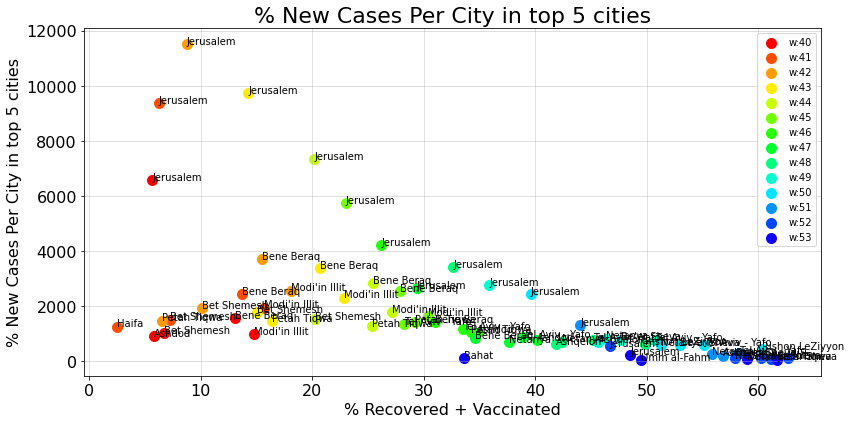

In [52]:
fig, ax = plt.subplots(1, 1)
pearson_coeff = []
spearman_coeff = []
colors = get_cmap(20)
num_cities = 5
for i, (w, df_w) in enumerate(geo_stats_40.groupby('weeks_from')):
    df_w = df_w[df_w.accumulated_cases > 100] 
    df_w = df_w.sort_values(ascending=False, by='new_cases_on_date')
    df_w = df_w.iloc[:num_cities,:]
    percentage_accumulated_r = df_w['percentage_accumulated_vaccination_second_dose'] + df_w['percentage_accumulated_recoveries']
#     percentage_new_cases = 100 * (df_w['new_cases_on_date'] / df_w['new_cases_on_date_country'])
#     percentage_new_cases =  df_w['percentage_new_cases_on_date'] #- df_w['percentage_new_cases_on_date_country'])
    percentage_new_cases =  df_w['new_cases_on_date']
    df_w['percentage_new_cases'] = percentage_new_cases
    ax.scatter(percentage_accumulated_r, percentage_new_cases, label=f'w:{w}', color=colors[i])
    p_coeff, _ = pearsonr(percentage_accumulated_r, df_w.percentage_new_cases_on_date)
    s_coeff, _ = spearmanr(percentage_accumulated_r, df_w.percentage_new_cases_on_date)
    pearson_coeff.append(p_coeff)
    spearman_coeff.append(s_coeff)
    for x, y, c in zip(percentage_accumulated_r, percentage_new_cases, df_w['town_english']):
        plt.text(x, y, c)
# ax.scatter(geo_stats_40.percentage_accumulated_immuned_country, geo_stats_40.percentage_new_cases_on_date_country, c='k', label='Israel')
ax.set_xlabel('% Recovered + Vaccinated')
ax.set_title(f'% New Cases Per City in top {num_cities} cities')
ax.set_ylabel(f'% New Cases Per City in top {num_cities} cities')
ax.legend()
ax.grid()
# ax.plot([55, 55], [0, 0.2], linestyle='--', linewidth=3, color='k')
ax.plot()

In [53]:
sorted_data = geo_stats_40.sort_values(ascending=False,by=['weeks_from', 'median_age'])
sorted_data.dropna()

,weeks_from,new_hospitalizations_on_date_country,new_cases_on_date_country,accumulated_immuned_country,accumulated_cases_country,town_code,city,town_english,city_name,num_population,...,accumulated_immuned,percentage_accumulated_cases_country,percentage_accumulated_immuned_country,percentage_accumulated_cases_by_tot,new_cases_on_date,new_hospitalizations_on_date,percentage_new_cases_on_date,percentage_new_hospitalizations_on_date,percentage_new_cases_on_date_country,percentage_new_hospitalizations_on_date_country
14145,53,58.0,2081.0,4875761.0,761140.0,9600,קריית ים,Qiryat Yam,קריית ים,39887.45,...,23658.0,8.273261,52.997402,0.261187,8.0,0.0,0.020056,0.0,0.02262,0.000630
14112,53,58.0,2081.0,4875761.0,761140.0,6200,בת ים,Bat Yam,בת ים,128741.96,...,83167.0,8.273261,52.997402,1.238800,18.0,0.0,0.013981,0.0,0.02262,0.000630
14004,53,58.0,2081.0,4875761.0,761140.0,1167,קיסריה,Qesaryya,קיסריה,5374.59,...,4120.0,8.273261,52.997402,0.031926,0.0,0.0,0.000000,0.0,0.02262,0.000630
14042,53,58.0,2081.0,4875761.0,761140.0,2300,קריית טבעון,Qiryat Tiv'on,קריית טבעון,18211.82,...,12128.0,8.273261,52.997402,0.074099,4.0,0.0,0.021964,0.0,0.02262,0.000630
14131,53,58.0,2081.0,4875761.0,761140.0,8200,קריית מוצקין,Qiryat Motzkin,קריית מוצקין,43268.42,...,31145.0,8.273261,52.997402,0.293244,2.0,0.0,0.004622,0.0,0.02262,0.000630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10616,40,142.0,31947.0,353800.0,396865.0,1303,חורה,Hura,חורה,22301.92,...,490.0,4.313750,3.845652,0.130271,16.0,0.0,0.071743,0.0,0.34725,0.001543
10618,40,142.0,31947.0,353800.0,396865.0,1309,אלעד,El'ad,אלעד,48736.39,...,5853.0,4.313750,3.845652,1.590717,363.0,0.0,0.744823,0.0,0.34725,0.001543
10687,40,142.0,31947.0,353800.0,396865.0,3779,כוכב יעקב,Kokhav Ya'aqov,כוכב יעקב,8547.22,...,580.0,4.313750,3.845652,0.181170,100.0,0.0,1.169971,0.0,0.34725,0.001543
10688,40,142.0,31947.0,353800.0,396865.0,3780,ביתר עילית,Betar Illit,ביתר עילית,59173.85,...,6291.0,4.313750,3.845652,1.783226,627.0,0.0,1.059590,0.0,0.34725,0.001543


In [77]:
get_cmap(20, 'adf')

ValueError: 'adf' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

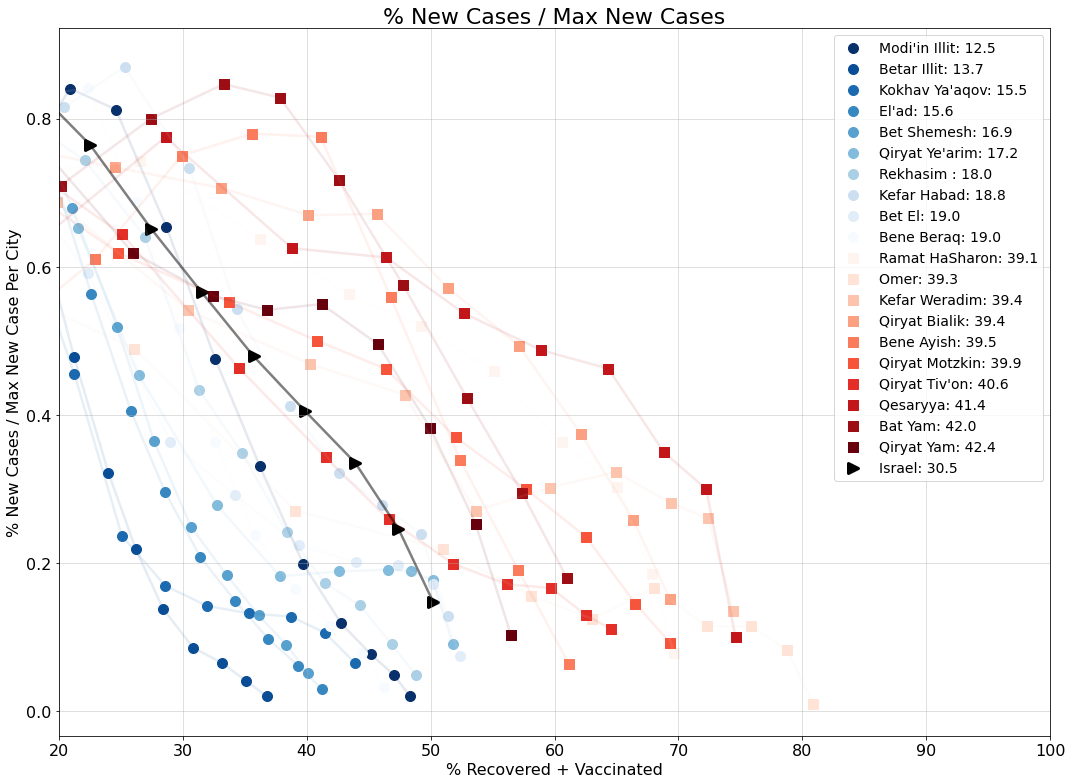

In [108]:
# cities = ["ירושלים", "בת ים", "בני ברק" ]

sorted_data = geo_stats_40.sort_values(ascending=True,by=['weeks_from', 'median_age']).dropna()
cities_young = list(sorted_data[sorted_data.weeks_from == 53].iloc()[:19, :].town)
cities_old = list(sorted_data[sorted_data.weeks_from == 53].iloc()[-10:, :].town)
cities = cities_young + cities_old
colors = get_cmap(20)
colors_o = get_cmap(10, 'Reds')
colors_y = get_cmap(10, 'Blues_r')
symbol_o = 's'
symbol_y = 'o'
plt.rcParams["figure.figsize"] = (15, 11)
n_young = len(cities_young)
young_cities_data = np.zeros(shape=(sorted_data.weeks_from.unique().size, 30))
old_cities_data = np.zeros(shape=(sorted_data.weeks_from.unique().size, 30))
i_young = 0
for i, c in enumerate(cities):
    city_data = geo_stats_40[geo_stats_40['town'] == c]
    c_english = city_data.town_english.iloc[0]
    median_age =  city_data.median_age.iloc[0]
    percentage_accumulated = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
    percentage_new_cases= city_data['new_cases_on_date']/ np.max(city_data['new_cases_on_date'])
#     percentage_new_cases= city_data['percentage_new_cases_on_date'] / city_data['percentage_new_cases_on_date_country']

    percentage_new_cases_s = moving_average(percentage_new_cases, 4)
    percentage_accumulated_s = moving_average(percentage_accumulated, 4)
    if np.max(percentage_accumulated_s)>35:
        if i<n_young:
            color_to_use = colors_y[i_young]
            marker_to_use = symbol_y
            young_cities_data[:, i] = percentage_new_cases
            i_young += 1
        else:
            marker_to_use = symbol_o
            color_to_use = colors_o[i-n_young]
            old_cities_data[:, i-n_young] = percentage_new_cases
        plt.plot(percentage_accumulated_s, percentage_new_cases_s, color=color_to_use, alpha=0.1)
        plt.scatter(percentage_accumulated_s, percentage_new_cases_s, label=f"{c_english}: {median_age}", color=color_to_use, marker=marker_to_use)

percentage_accumulated_country_s = moving_average(city_data['percentage_accumulated_immuned_country'], 4)
percentage_new_cases_country_s = moving_average(city_data['percentage_new_cases_on_date_country']/np.max(city_data['percentage_new_cases_on_date_country']), 4)
plt.plot(percentage_accumulated_country_s, percentage_new_cases_country_s, color='k', alpha=0.5)
plt.scatter(percentage_accumulated_country_s, percentage_new_cases_country_s, label=f"Israel: 30.5", color='k', marker='>', linewidth=3)

plt.grid()
plt.legend(fontsize=14)
plt.xlabel('% Recovered + Vaccinated')
plt.title(f'% New Cases / Max New Cases')
plt.ylabel(f'% New Cases / Max New Case Per City')
plt.xlim([20, 100])
plt.plot()
plt.savefig("new_cases_per_max_cases_cities.png", dpi=300, facecolor='white')

In [101]:
# plt.scatter(city_data.weeks_from, city_data.percentage_new_cases_on_date_country, label=f"Israel: 30.5", color='k', marker='o')

In [57]:
# # cities = ["ירושלים", "בת ים", "בני ברק" ]

# sorted_data = geo_stats_40.sort_values(ascending=False,by=['weeks_from', 'median_age']).dropna()
# cities_young = list(sorted_data[sorted_data.weeks_from == 53].iloc()[:10, :].town)
# cities_old = list(sorted_data[sorted_data.weeks_from == 53].iloc()[-10:, :].town)
# cities = cities_young + cities_old
# colors = get_cmap(20)
# colors_o = get_cmap(10, 'winter')
# colors_y = get_cmap(10, 'rocket_r')
# plt.rcParams["figure.figsize"] = (15, 11)
# n_young = len(cities_young)
# young_cities_data = np.zeros(shape=(sorted_data.weeks_from.unique().size, 20))
# old_cities_data = np.zeros(shape=(sorted_data.weeks_from.unique().size, 20))
# for i, c in enumerate(cities):
#     city_data = geo_stats_40[geo_stats_40['town'] == c]
#     c_english = city_data.town_english.iloc[0]
#     median_age =  city_data.median_age.iloc[0]
#     percentage_accumulated = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
#     percentage_new_cases= city_data['new_hospitalizations_on_date']/ np.max(city_data['new_hospitalizations_on_date'])
# #     percentage_new_cases= city_data['percentage_new_cases_on_date'] / city_data['percentage_new_cases_on_date_country']

#     percentage_new_cases_s = moving_average(percentage_new_cases, 4)
#     percentage_accumulated_s = moving_average(percentage_accumulated, 4)
#     if i<n_young:
#         color_to_use = colors_y[i]
#         young_cities_data[:, i] = percentage_new_cases
#     else:
#         color_to_use = colors_o[i-n_young]
#         old_cities_data[:, i-n_young] = percentage_new_cases
#     plt.plot(percentage_accumulated_s, percentage_new_cases_s, color=color_to_use, alpha=0.1)
#     plt.scatter(percentage_accumulated_s, percentage_new_cases_s, label=f"{c_english}: {median_age}", color=color_to_use, marker='*')
# plt.grid()
# plt.legend(fontsize=14)
# plt.xlabel('% Vaccinations + Recovered')
# plt.title(f'% New Cases / Max New Cases')
# plt.ylabel(f'% New Cases / Max New Case Per City')
# plt.xlim([15, 100])
# plt.plot()

In [58]:
# sorted_data = geo_stats_40.sort_values(ascending=False,by=['weeks_from', 'percentage_accumulated_immuned_normalized'])
# cities = list(sorted_data[sorted_data.weeks_from == 53].iloc[[0, 1, 2, 3, 4, 5], :].town)
# cities.append("ירושלים")

/Users/chanaross/opt/anaconda3/envs/py38_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chanaross/opt/anaconda3/envs/py38_env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chanaross/opt/anaconda3/envs/py38_env/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/chanaross/opt/anaconda3/envs/py38_env/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/chanaross/opt/anaconda3/envs/py38_env/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret =

Text(0, 0.5, 'mean d(accumulated)/dt')

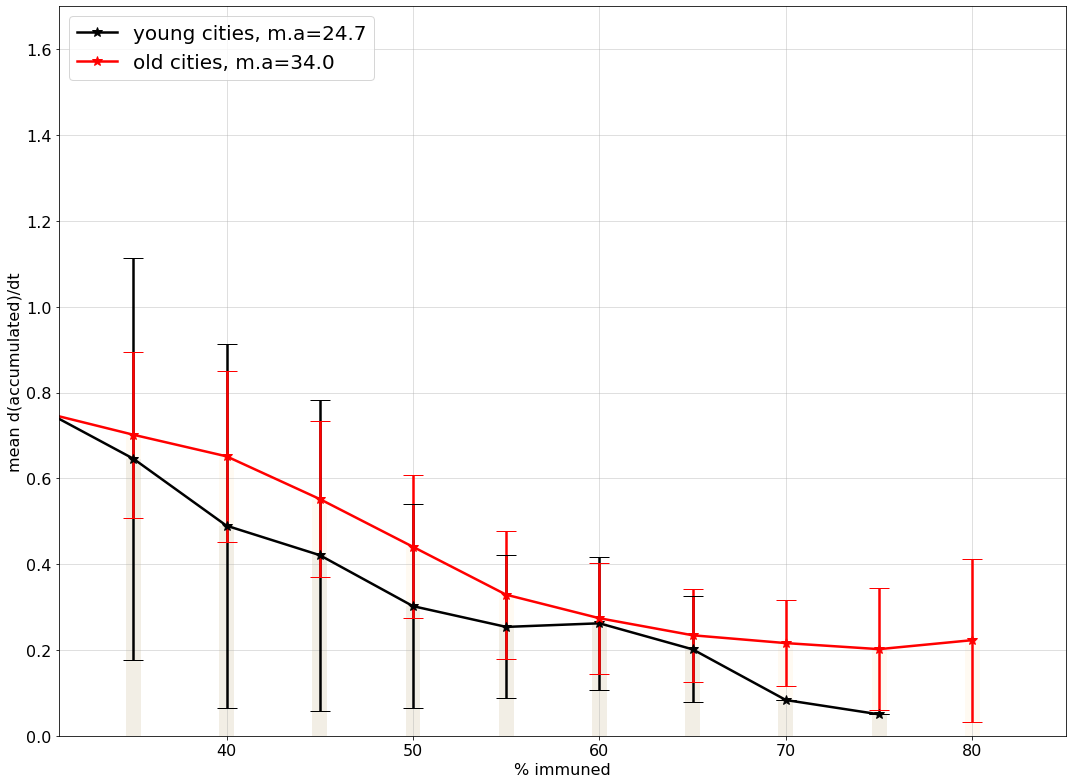

In [103]:
per_immu_young = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_young = geo_stats_40[geo_stats_40.median_age<np.mean(geo_stats_40.median_age)].dropna()
median_age_young = np.median(geo_stats_40_young.median_age)
for c in geo_stats_40_young.town.unique():
    city_data = geo_stats_40[geo_stats_40['town'] == c]
    c_english = city_data.town_english.iloc[0]
    diff_accu = moving_average(np.diff(city_data['accumulated_cases']), 4)
    diff_accu = diff_accu/(diff_accu[0]+1e-5)
    mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
    if diff_accu.max()<100:
        for a, p in zip(diff_accu, mean_per_immu):
            index = int(p//5)
            per_immu_young[(index+1) * 5].append(a)
mean_acc_diff = [np.mean(l) for l in per_immu_young.values()]
std_acc_diff = [np.std(l) for l in per_immu_young.values()]
plt.plot(per_immu_young.keys(), mean_acc_diff, marker='*', color='k', label=f'young cities, m.a={median_age_young}')
# plt.grid()
plt.bar(per_immu_young.keys(), mean_acc_diff,
       yerr=std_acc_diff,
       align='center',
       alpha=0.05,
       ecolor='black',
       capsize=10, color='k')
plt.xlim([30, 100])
plt.grid()
per_immu_old = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_old = geo_stats_40[geo_stats_40.median_age>np.mean(geo_stats_40.median_age)].dropna()
median_age_old = np.median(geo_stats_40_old.median_age)

for c in geo_stats_40_old.town.unique():
    city_data = geo_stats_40[geo_stats_40['town'] == c]
    c_english = city_data.town_english.iloc[0]
    diff_accu = moving_average(np.diff(city_data['accumulated_cases']), 4)
    diff_accu = diff_accu/(np.max(diff_accu))
    mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
    if diff_accu.max()<100:
        for a, p in zip(diff_accu, mean_per_immu):
            index = int(p//5)
            per_immu_old[(index+1) * 5].append(a)
mean_acc_diff = [np.mean(l) for l in per_immu_old.values()]
std_acc_diff = [np.std(l) for l in per_immu_old.values()]
plt.plot(per_immu_old.keys(), mean_acc_diff, marker='*', color='r', label=f'old cities, m.a={median_age_old}')
plt.grid()
# plt.figure()
plt.bar(per_immu_old.keys(), mean_acc_diff,
       yerr=std_acc_diff,
       align='center',
       alpha=0.05,
       ecolor='red',
       capsize=10, color='orange')
# aa=[k-10 for k in per_immu.keys()]
# plt.plot(aa, mean_acc_diff, marker='*', color='g', label='moved')

# plt.yscale('symlog')
plt.xlim([31, 85])
plt.ylim([0, 1.7])
plt.grid()
plt.legend(fontsize=20)
plt.xlabel("% immuned")
plt.ylabel("mean d(accumulated)/dt")

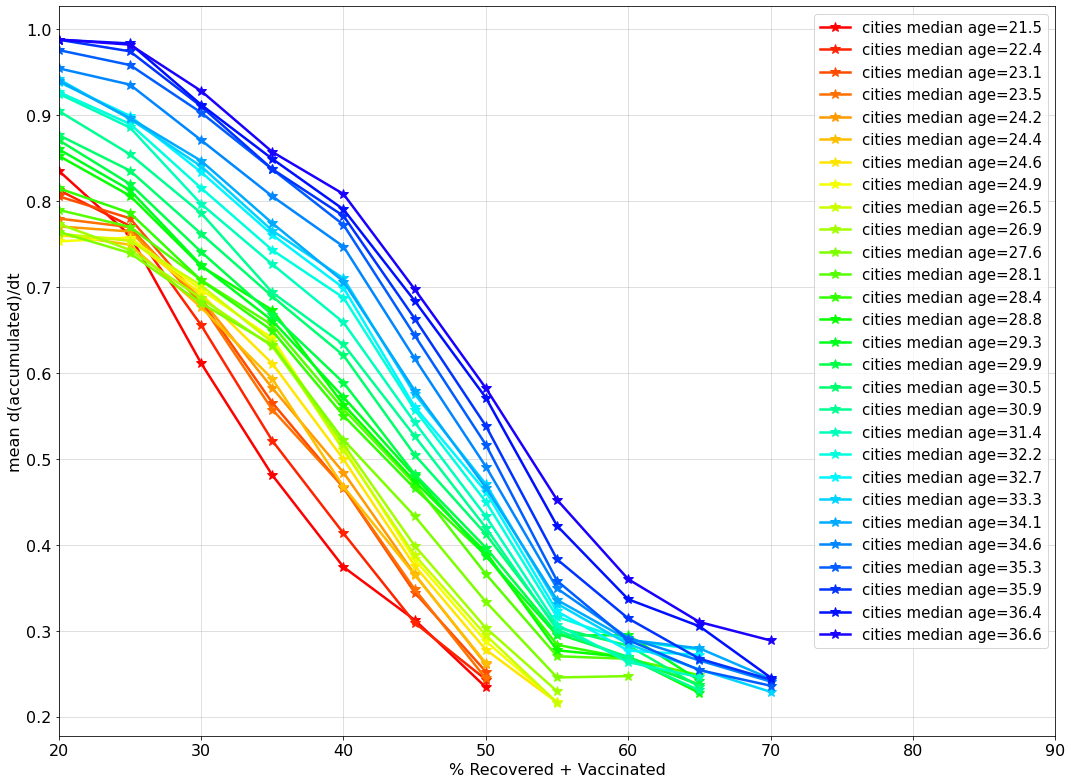

In [109]:
plt.rcParams["figure.figsize"] = (15, 11)

per_immu_young = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_ordered = geo_stats_40.sort_values(by='median_age').dropna()
n_cities = 50
step_size = 5
buffer = 0
colors = get_cmap(40) # 'Spectral'
for i_color, i_c in enumerate(np.arange(buffer, geo_stats_40_ordered['town'].unique().shape[0] - n_cities - buffer, step_size)):
    cities = geo_stats_40_ordered.town.unique()[i_c: i_c + n_cities]
    median_age_cities = []
    total_population_cities = 0
    population_temp = []
    per_immu_cities = {k: [] for k in np.arange(5, 105,5)}
    
    for c in cities:
        city_data = geo_stats_40[geo_stats_40['town'] == c]
        c_english = city_data.town_english.iloc[0]
        median_age_cities.append(city_data.median_age.iloc[0] * city_data.num_population.iloc[0])
        population_temp.append(city_data.num_population.iloc[0])
        total_population_cities += city_data.num_population.iloc[0]
        city_data = city_data[city_data.percentage_accumulated_immuned >= 5]
        if city_data.size>0:
            diff_accu = moving_average(np.diff(city_data['accumulated_cases']), 4)
            mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
            diff_accu = diff_accu/(np.max(diff_accu)+1e-5)
            if diff_accu.max()<100:
                for a, p in zip(diff_accu, mean_per_immu):
                    index = int(p//5)
                    per_immu_cities[(index+1) * 5].append(a)
#     print(f"{i_color}: {cities}, n population:{population_temp}")
    median_age_cities = np.sum(median_age_cities)/total_population_cities
    mean_acc_diff = [np.mean(l) for l in per_immu_cities.values() if len(l)> 8]
    std_acc_diff = [np.std(l) for l in per_immu_cities.values() if len(l)> 8]
    per_for_plot = [p for p, v in per_immu_cities.items() if len(v)>8]
    plt.plot(per_for_plot, mean_acc_diff, marker='*', color=colors[i_color], label=f'cities median age={np.round(median_age_cities, 1).astype(float)}')

    
# per_immu_cities = {k: [] for k in np.arange(5, 105,5)}
# diff_accu = moving_average(np.diff(city_data['accumulated_cases_country']), 4)
# diff_accu = diff_accu/(np.max(diff_accu)+1e-5)
# mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned_country'], 4)[:-1]
# if diff_accu.max()<100:
#     for a, p in zip(diff_accu, mean_per_immu):
#         index = int(p//5)
#         per_immu_cities[(index+1) * 5].append(a)
#     print(f"{i_color}: {cities}, n population:{population_temp}")
# mean_acc_diff = [np.mean(l) for l in per_immu_cities.values()]
# std_acc_diff = [np.std(l) for l in per_immu_cities.values()]
# per_for_plot = [p for p, v in per_immu_cities.items()]
# median_age_israel = np.median(geo_stats_40[geo_stats_40.weeks_from == 43].median_age.dropna())
# plt.plot(per_for_plot, mean_acc_diff, marker='o', color='k', label=f'Israel median age={np.round(median_age_israel, 1).astype(float)}')


plt.grid()
plt.legend(fontsize=15)
plt.xlim([20, 90])
plt.xlabel("% Recovered + Vaccinated")
plt.ylabel("mean d(accumulated)/dt")
plt.savefig("mean_derivative_of_accumulated_cases_per_median_age.png",  dpi=300, facecolor='white')

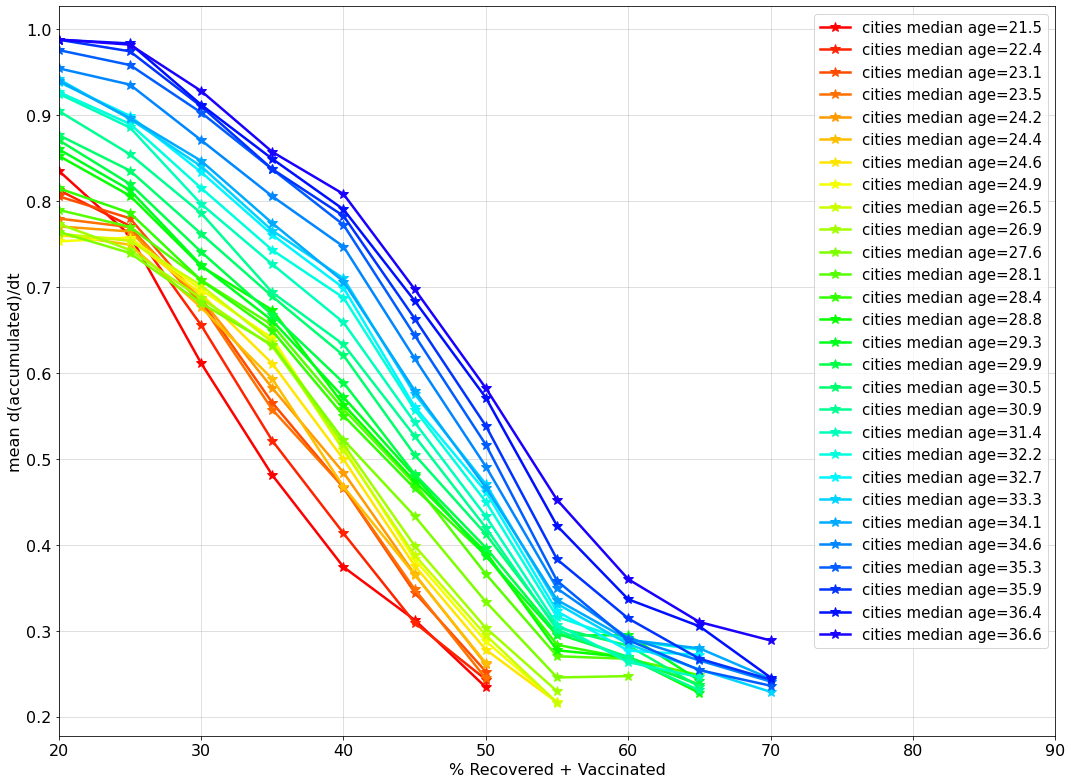

In [110]:
plt.rcParams["figure.figsize"] = (15, 11)

per_immu_young = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_ordered = geo_stats_40.sort_values(by='median_age').dropna()
n_cities = 50
step_size = 5
buffer = 0
colors = get_cmap(40) # 'Spectral'
fig1, ax1 = plt.subplots(1, 1)
for i_color, i_c in enumerate(np.arange(buffer, geo_stats_40_ordered['town'].unique().shape[0] - n_cities - buffer, step_size)):
    cities = geo_stats_40_ordered.town.unique()[i_c: i_c + n_cities]
    median_age_cities = []
    total_population_cities = 0
    population_temp = []
    per_immu_cities = {k: [] for k in np.arange(5, 105,5)}
    
    for c in cities:
        city_data = geo_stats_40[geo_stats_40['town'] == c]
        c_english = city_data.town_english.iloc[0]
        median_age_cities.append(city_data.median_age.iloc[0] * city_data.num_population.iloc[0])
        population_temp.append(city_data.num_population.iloc[0])
        total_population_cities += city_data.num_population.iloc[0]
        city_data = city_data[city_data.percentage_accumulated_immuned >= 5]
        if city_data.size>0:
            diff_accu = moving_average(np.diff(city_data['accumulated_cases']), 4)
            mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
            diff_accu = diff_accu/(np.max(diff_accu)+1e-5)
            if diff_accu.max()<100:
                for a, p in zip(diff_accu, mean_per_immu):
                    index = int(p//5)
                    per_immu_cities[(index+1) * 5].append(a)
#     print(f"{i_color}: {cities}, n population:{population_temp}")
    median_age_cities = np.sum(median_age_cities)/total_population_cities
    mean_acc_diff = [np.mean(l) for l in per_immu_cities.values() if len(l)> 8]
    std_acc_diff = [np.std(l) for l in per_immu_cities.values() if len(l)> 8]
    per_for_plot = [p for p, v in per_immu_cities.items() if len(v)>8]
    ax1.plot(per_for_plot, mean_acc_diff, marker='*', color=colors[i_color], label=f'cities median age={np.round(median_age_cities, 1).astype(float)}')

    
# per_immu_cities = {k: [] for k in np.arange(5, 105,5)}
# diff_accu = moving_average(np.diff(city_data['accumulated_cases_country']), 4)
# diff_accu = diff_accu/(np.max(diff_accu)+1e-5)
# mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned_country'], 4)[:-1]
# if diff_accu.max()<100:
#     for a, p in zip(diff_accu, mean_per_immu):
#         index = int(p//5)
#         per_immu_cities[(index+1) * 5].append(a)
#     print(f"{i_color}: {cities}, n population:{population_temp}")
# mean_acc_diff = [np.mean(l) for l in per_immu_cities.values()]
# std_acc_diff = [np.std(l) for l in per_immu_cities.values()]
# per_for_plot = [p for p, v in per_immu_cities.items()]
# median_age_israel = np.median(geo_stats_40[geo_stats_40.weeks_from == 43].median_age.dropna())
# plt.plot(per_for_plot, mean_acc_diff, marker='o', color='k', label=f'Israel median age={np.round(median_age_israel, 1).astype(float)}')


plt.grid()
plt.legend(fontsize=15)
plt.xlim([20, 90])
plt.xlabel("% Recovered + Vaccinated")
plt.ylabel("mean d(accumulated)/dt")
plt.savefig("mean_derivative_of_accumulated_cases_per_median_age.png",  dpi=300, facecolor='white')

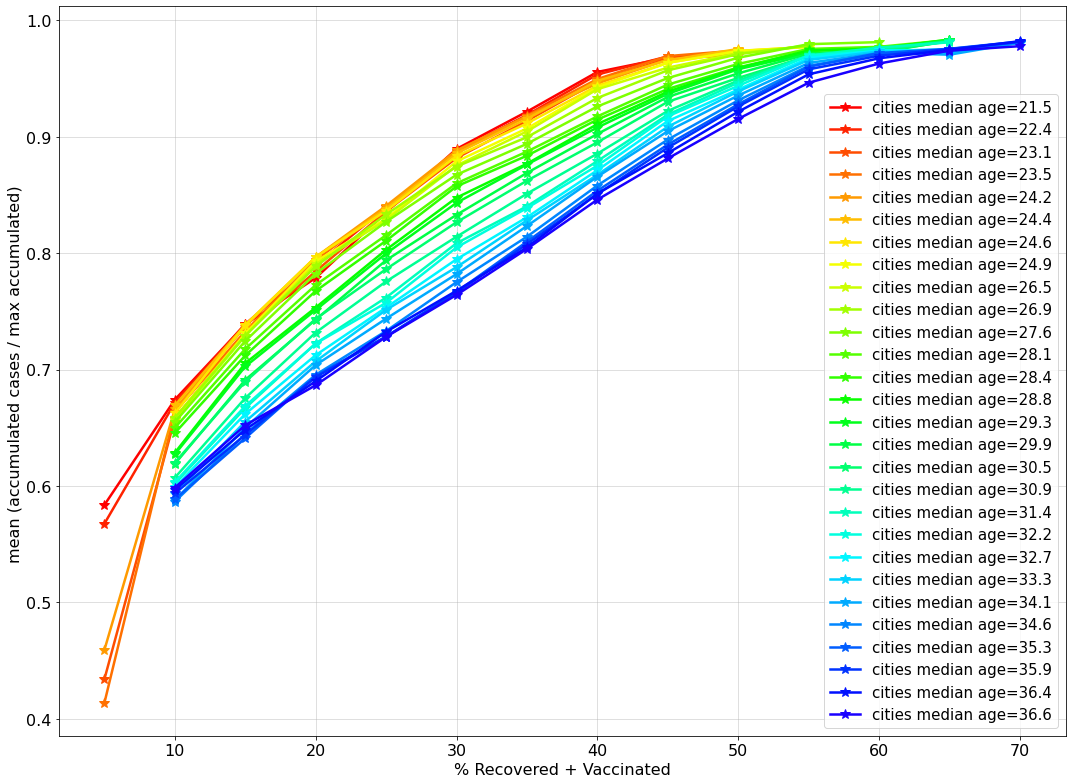

In [111]:
plt.rcParams["figure.figsize"] = (15, 11)

per_immu_young = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_ordered = geo_stats_40.sort_values(by='median_age').dropna()
n_cities = 50
step_size = 5
buffer = 0
colors = get_cmap(40) # 'Spectral'
for i_color, i_c in enumerate(np.arange(buffer, geo_stats_40_ordered['town'].unique().shape[0] - n_cities - buffer, step_size)):
    cities = geo_stats_40_ordered.town.unique()[i_c: i_c + n_cities]
    median_age_cities = []
    total_population_cities = 0
    population_temp = []
    per_immu_cities = {k: [] for k in np.arange(5, 105,5)}
    
    for c in cities:
        city_data = geo_stats_40[geo_stats_40['town'] == c]
        c_english = city_data.town_english.iloc[0]
        median_age_cities.append(city_data.median_age.iloc[0] * city_data.num_population.iloc[0])
        population_temp.append(city_data.num_population.iloc[0])
        total_population_cities += city_data.num_population.iloc[0]
        diff_accu = moving_average((city_data['accumulated_cases']), 4)
        diff_accu = diff_accu/(np.max(diff_accu)+1e-5)
        mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
        if diff_accu.max()<100:
            for a, p in zip(diff_accu, mean_per_immu):
                index = int(p//5)
                per_immu_cities[(index+1) * 5].append(a)
#     print(f"{i_color}: {cities}, n population:{population_temp}")
    median_age_cities = np.sum(median_age_cities)/total_population_cities
    mean_acc_diff = [np.mean(l) for l in per_immu_cities.values() if len(l)> 8]
    std_acc_diff = [np.std(l) for l in per_immu_cities.values() if len(l)> 8]
    per_for_plot = [p for p, v in per_immu_cities.items() if len(v)>8]
    plt.plot(per_for_plot, mean_acc_diff, marker='*', color=colors[i_color], label=f'cities median age={np.round(median_age_cities, 1).astype(float)}')
plt.grid()
plt.legend(fontsize=15)
# plt.xlim([25, 90])
plt.xlabel("% Recovered + Vaccinated")
plt.ylabel("mean (accumulated cases / max accumulated) ")
plt.savefig("mean_accumulated_cases_per_median_age.png",  dpi=300, facecolor='white')

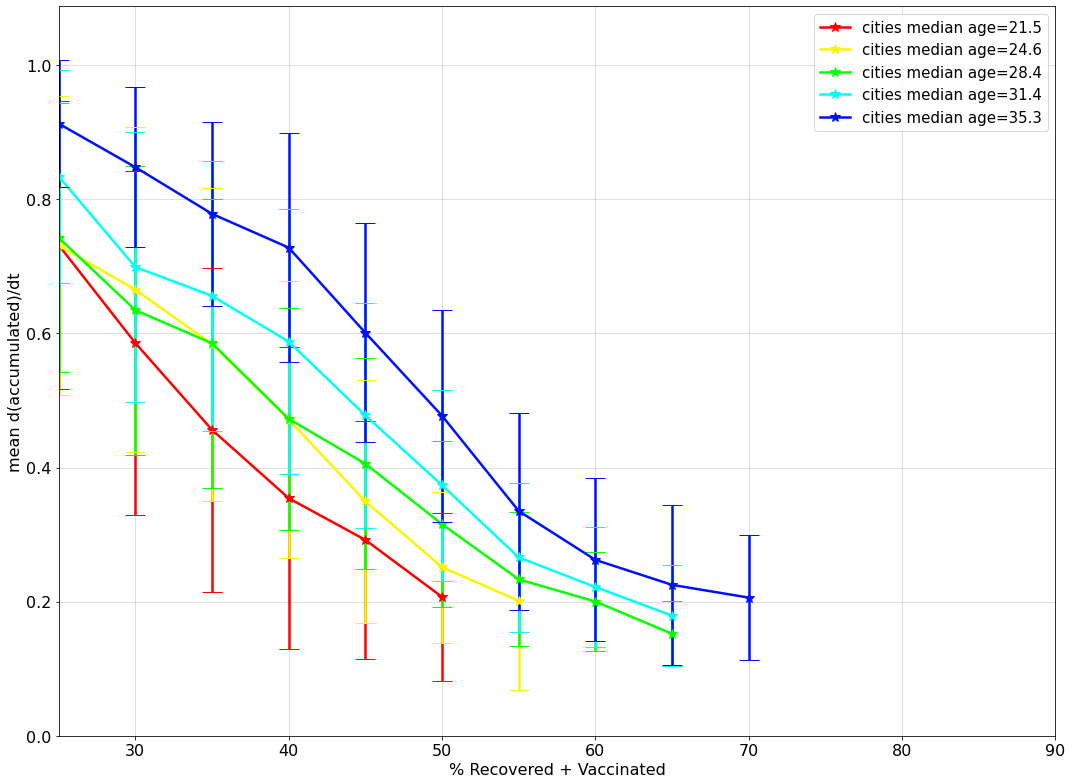

In [112]:
plt.rcParams["figure.figsize"] = (15, 11)

per_immu_young = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_ordered = geo_stats_40.sort_values(by='median_age').dropna()
n_cities = 50
step_size = 30
buffer = 0
colors = get_cmap(7) # 'Spectral'
for i_color, i_c in enumerate(np.arange(buffer, geo_stats_40_ordered['town'].unique().shape[0] - n_cities - buffer, step_size)):
    cities = geo_stats_40_ordered.town.unique()[i_c: i_c + n_cities]
    median_age_cities = []
    total_population_cities = 0
    population_temp = []
    per_immu_cities = {k: [] for k in np.arange(5, 105,5)}
    
    for c in cities:
        city_data = geo_stats_40[geo_stats_40['town'] == c]
        c_english = city_data.town_english.iloc[0]
        median_age_cities.append(city_data.median_age.iloc[0] * city_data.num_population.iloc[0])
        population_temp.append(city_data.num_population.iloc[0])
        total_population_cities += city_data.num_population.iloc[0]
        diff_accu = moving_average(np.diff(city_data['accumulated_cases']), 4)
        diff_accu = diff_accu/(np.max(diff_accu)+1e-5)
        mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
        if diff_accu.max()<100:
            for a, p in zip(diff_accu, mean_per_immu):
                index = int(p//5)
                per_immu_cities[(index+1) * 5].append(a)
#     print(f"{i_color}: {cities}, n population:{population_temp}")
    median_age_cities = np.sum(median_age_cities)/total_population_cities
    mean_acc_diff = [np.mean(l) for l in per_immu_cities.values() if len(l)> 8]
    std_acc_diff = [np.std(l) for l in per_immu_cities.values() if len(l)> 8]
    per_for_plot = [p for p, v in per_immu_cities.items() if len(v)>8]
    plt.plot(per_for_plot, mean_acc_diff, marker='*', color=colors[i_color], label=f'cities median age={np.round(median_age_cities, 1).astype(float)}')
    plt.bar(per_for_plot, mean_acc_diff,
       yerr=std_acc_diff,
       align='center',
       alpha=0.001,
       ecolor=colors[i_color],
       capsize=10, color=colors[i_color])
plt.grid()
plt.legend(fontsize=15)
plt.xlim([25, 90])
plt.xlabel("% Recovered + Vaccinated")
plt.ylabel("mean d(accumulated)/dt")
plt.savefig("mean_std_derivative_of_accumulated_cases_per_median_age.png",  dpi=300, facecolor='white')

In [64]:
# data_vacc_per_age = create_vacc_efficiency_per_city(geo_vacc_per_age, 'ירושלים')
# data_vacc_impact = get_num_vaccinations_per_week_per_city_with_age_factors(data_vacc_per_age, impact_factor_per_age)

In [65]:
data_vacc_per_age = create_vacc_efficiency_per_city(geo_vacc_per_age, 'ירושלים')
data_vacc_impact = get_num_vaccinations_per_week_per_city_with_age_factors(data_vacc_per_age, impact_factor_per_age)

Text(0, 0.5, 'mean d(accumulated)/dt')

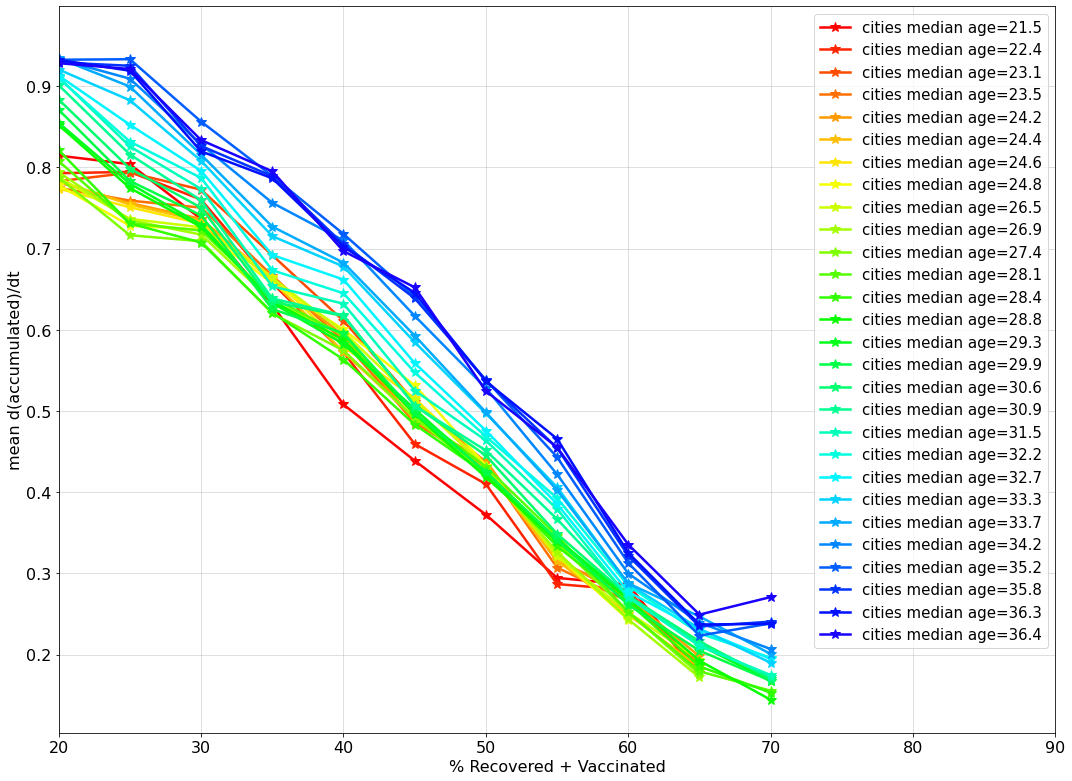

In [113]:

plt.rcParams["figure.figsize"] = (15, 11)

per_immu_young = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_ordered = geo_stats_40.sort_values(by='median_age').dropna()
n_cities = 50
step_size = 5
buffer = 0
colors = get_cmap(40) # 'Spectral'
for i_color, i_c in enumerate(np.arange(buffer, geo_stats_40_ordered['town'].unique().shape[0] - n_cities - buffer, step_size)):
    cities = geo_stats_40_ordered.town.unique()[i_c: i_c + n_cities]
    median_age_cities = []
    total_population_cities = 0
    population_temp = []
    per_immu_cities = {k: [] for k in np.arange(5, 105,5)}
    for c in cities:
        if c in geo_vacc_per_age.CityName.values:
            city_data = geo_stats_40[geo_stats_40['town'] == c]
            c_english = city_data.town_english.iloc[0]
            median_age = city_data.median_age.iloc[0] 
            median_age_cities.append(median_age* city_data.num_population.iloc[0])
            population_temp.append(city_data.num_population.iloc[0])
            total_population_cities += city_data.num_population.iloc[0]
            diff_accu = moving_average(np.diff(city_data['accumulated_cases']), 4)
            diff_accu = diff_accu/(np.max(diff_accu)+1e-5)
            data_vacc_per_age = create_vacc_efficiency_per_city(geo_vacc_per_age, c)
            data_vacc_impact = get_num_vaccinations_per_week_per_city_with_age_factors(data_vacc_per_age, impact_factor_per_age)
            num_vacc_corrected = data_vacc_impact.num_accumulated_vacc.values
            percentage_vacc_corrected = 100 * num_vacc_corrected / city_data.num_population.iloc[0]
            impact_median = f_impact(median_age)
            percentage_recoveries_corrected = city_data['percentage_accumulated_recoveries'] * impact_median
            percentage_immuned_corrected = percentage_vacc_corrected[1:-1] + percentage_recoveries_corrected
            mean_per_immu =  moving_average(percentage_immuned_corrected, 4)[:-1]
            if diff_accu.max()<100:
                for a, p in zip(diff_accu, mean_per_immu):
                    index = int(p//5)
                    per_immu_cities[(index+1) * 5].append(a)
#     print(f"{i_color}: {cities}, n population:{population_temp}")
    median_age_cities = np.sum(median_age_cities)/total_population_cities
    mean_acc_diff = [np.mean(l) for l in per_immu_cities.values() if len(l)> 8]
    std_acc_diff = [np.std(l) for l in per_immu_cities.values() if len(l)> 8]
    per_for_plot = [p for p, v in per_immu_cities.items() if len(v)>8]
    plt.plot(per_for_plot, mean_acc_diff, marker='*', color=colors[i_color], label=f'cities median age={np.round(median_age_cities, 1).astype(float)}')

plt.grid()
plt.legend(fontsize=15)
plt.xlim([20, 90])
plt.xlabel("% Recovered + Vaccinated")
plt.ylabel("mean d(accumulated)/dt")
# plt.savefig("mean_derivative_of_accumulated_cases_corrected_per_median_age.png",  dpi=300, facecolor='white')

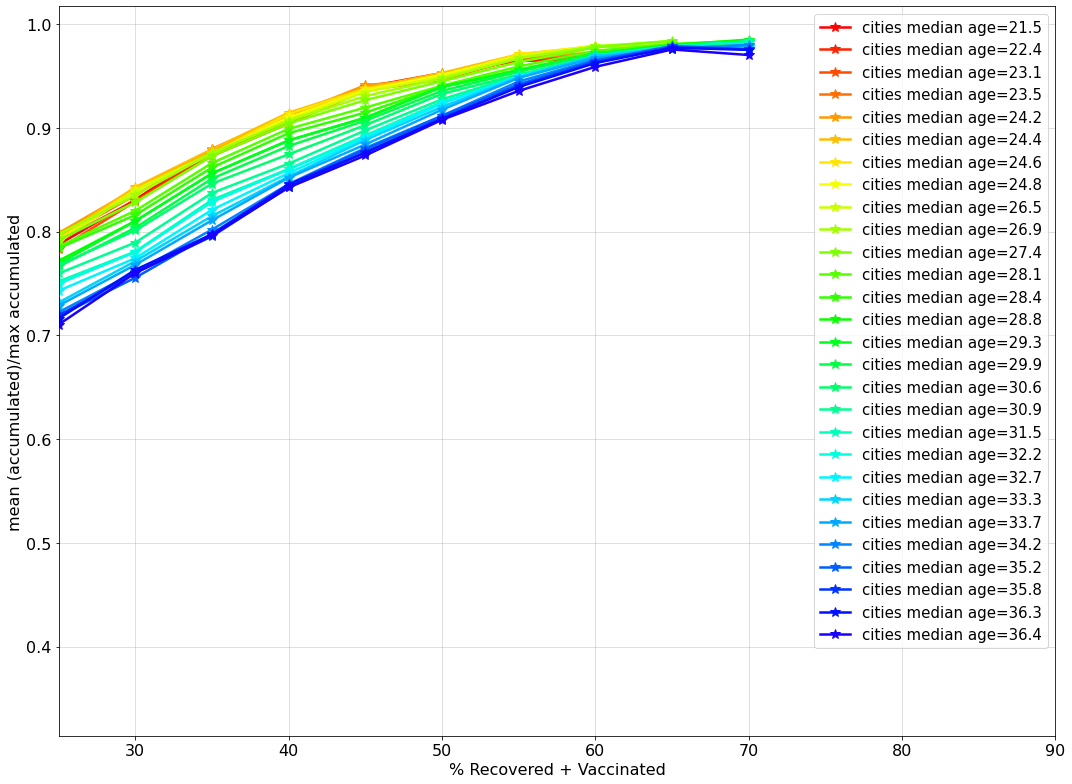

In [114]:

plt.rcParams["figure.figsize"] = (15, 11)

per_immu_young = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_ordered = geo_stats_40.sort_values(by='median_age').dropna()
n_cities = 50
step_size = 5
buffer = 0
colors = get_cmap(40) # 'Spectral'
for i_color, i_c in enumerate(np.arange(buffer, geo_stats_40_ordered['town'].unique().shape[0] - n_cities - buffer, step_size)):
    cities = geo_stats_40_ordered.town.unique()[i_c: i_c + n_cities]
    median_age_cities = []
    total_population_cities = 0
    population_temp = []
    per_immu_cities = {k: [] for k in np.arange(5, 105,5)}
    for c in cities:
        if c in geo_vacc_per_age.CityName.values:
            city_data = geo_stats_40[geo_stats_40['town'] == c]
            c_english = city_data.town_english.iloc[0]
            median_age = city_data.median_age.iloc[0] 
            median_age_cities.append(median_age* city_data.num_population.iloc[0])
            population_temp.append(city_data.num_population.iloc[0])
            total_population_cities += city_data.num_population.iloc[0]
            diff_accu = moving_average((city_data['accumulated_cases']), 4)
            diff_accu = diff_accu/(np.max(diff_accu)+1e-5)

            data_vacc_per_age = create_vacc_efficiency_per_city(geo_vacc_per_age, c)
            data_vacc_impact = get_num_vaccinations_per_week_per_city_with_age_factors(data_vacc_per_age, impact_factor_per_age)
            num_vacc_corrected = data_vacc_impact.num_accumulated_vacc.values
            percentage_vacc_corrected = 100 * num_vacc_corrected / city_data.num_population.iloc[0]
            impact_median = f_impact(median_age)
            percentage_recoveries_corrected = city_data['percentage_accumulated_recoveries'] * impact_median
            percentage_immuned_corrected = percentage_vacc_corrected[1:-1] + percentage_recoveries_corrected
            mean_per_immu =  moving_average(percentage_immuned_corrected, 4)[:-1]
            if diff_accu.max()<100:
                for a, p in zip(diff_accu, mean_per_immu):
                    index = int(p//5)
                    per_immu_cities[(index+1) * 5].append(a)
#     print(f"{i_color}: {cities}, n population:{population_temp}")
    median_age_cities = np.sum(median_age_cities)/total_population_cities
    mean_acc_diff = [np.mean(l) for l in per_immu_cities.values() if len(l)> 8]
    std_acc_diff = [np.std(l) for l in per_immu_cities.values() if len(l)> 8]
    per_for_plot = [p for p, v in per_immu_cities.items() if len(v)>8]
    plt.plot(per_for_plot, mean_acc_diff, marker='*', color=colors[i_color], label=f'cities median age={np.round(median_age_cities, 1).astype(float)}')

plt.grid()
plt.legend(fontsize=15)
plt.xlim([25, 90])
plt.xlabel("% Recovered + Vaccinated")
plt.ylabel("mean (accumulated)/max accumulated")
plt.savefig("mean_derivative_of_accumulated_cases_corrected_per_median_age.png",  dpi=300, facecolor='white')

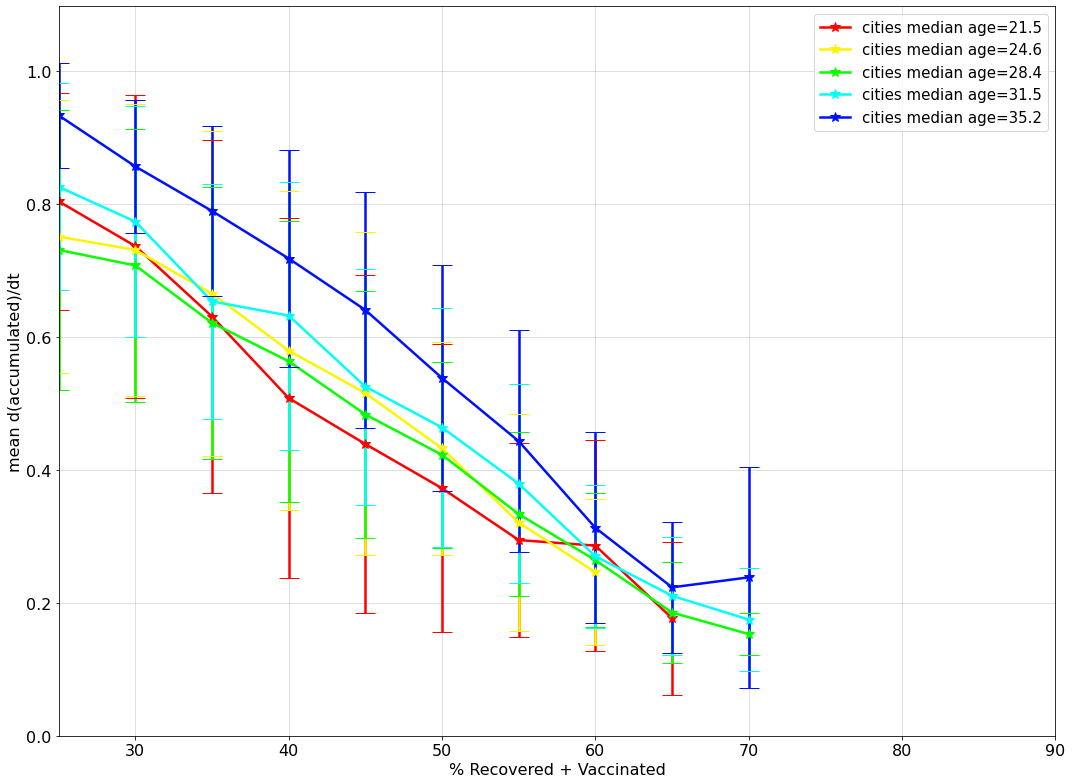

In [115]:

plt.rcParams["figure.figsize"] = (15, 11)

per_immu_young = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_ordered = geo_stats_40.sort_values(by='median_age').dropna()
n_cities = 50
step_size = 30
buffer = 0
colors = get_cmap(7) # 'Spectral'
for i_color, i_c in enumerate(np.arange(buffer, geo_stats_40_ordered['town'].unique().shape[0] - n_cities - buffer, step_size)):
    cities = geo_stats_40_ordered.town.unique()[i_c: i_c + n_cities]
    median_age_cities = []
    total_population_cities = 0
    population_temp = []
    per_immu_cities = {k: [] for k in np.arange(5, 105,5)}
    for c in cities:
        if c in geo_vacc_per_age.CityName.values:
            city_data = geo_stats_40[geo_stats_40['town'] == c]
            c_english = city_data.town_english.iloc[0]
            median_age = city_data.median_age.iloc[0] 
            median_age_cities.append(median_age* city_data.num_population.iloc[0])
            population_temp.append(city_data.num_population.iloc[0])
            total_population_cities += city_data.num_population.iloc[0]
            diff_accu = moving_average(np.diff(city_data['accumulated_cases']), 4)
            diff_accu = diff_accu/(np.max(diff_accu)+1e-5)

            data_vacc_per_age = create_vacc_efficiency_per_city(geo_vacc_per_age, c)
            data_vacc_impact = get_num_vaccinations_per_week_per_city_with_age_factors(data_vacc_per_age, impact_factor_per_age)
            num_vacc_corrected = data_vacc_impact.num_accumulated_vacc.values
            percentage_vacc_corrected = 100 * num_vacc_corrected / city_data.num_population.iloc[0]
            impact_median = f_impact(median_age)
            percentage_recoveries_corrected = city_data['percentage_accumulated_recoveries'] * impact_median
            percentage_immuned_corrected = percentage_vacc_corrected[1:-1] + percentage_recoveries_corrected
            mean_per_immu =  moving_average(percentage_immuned_corrected, 4)[:-1]
            if diff_accu.max()<100:
                for a, p in zip(diff_accu, mean_per_immu):
                    index = int(p//5)
                    per_immu_cities[(index+1) * 5].append(a)
#     print(f"{i_color}: {cities}, n population:{population_temp}")
    median_age_cities = np.sum(median_age_cities)/total_population_cities
    mean_acc_diff = [np.mean(l) for l in per_immu_cities.values() if len(l)> 8]
    std_acc_diff = [np.std(l) for l in per_immu_cities.values() if len(l)> 8]
    per_for_plot = [p for p, v in per_immu_cities.items() if len(v)>8]
    plt.plot(per_for_plot, mean_acc_diff, marker='*', color=colors[i_color], label=f'cities median age={np.round(median_age_cities, 1).astype(float)}')
    plt.bar(per_for_plot, mean_acc_diff,
       yerr=std_acc_diff,
       align='center',
       alpha=0.001,
       ecolor=colors[i_color],
       capsize=10, color=colors[i_color])
plt.grid()
plt.legend(fontsize=15)
plt.xlim([25, 90])
plt.xlabel("% Recovered + Vaccinated")
plt.ylabel("mean d(accumulated)/dt")
plt.savefig("mean_std_derivative_of_accumulated_cases_corrected_per_median_age.png",  dpi=300, facecolor='white')

In [69]:
# per_immu_young = {k: [] for k in np.arange(5, 105,5)}
# geo_stats_40_young = geo_stats_40[geo_stats_40.median_age<np.mean(geo_stats_40.median_age)]
# for c in geo_stats_40_young.town.unique():
#     city_data = geo_stats_40[geo_stats_40['town'] == c]
#     c_english = city_data.town_english.iloc[0]
#     del_acc = (np.max(city_data['accumulated_cases']) - np.min(city_data['accumulated_cases']))
#     accu = (city_data['accumulated_cases'] - np.min(city_data['accumulated_cases']))/del_acc   
#     diff_accu = moving_average(np.diff(accu), 4)
# #     diff_accu = diff_accu/(diff_accu[0]+1e-5)
#     mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
#     if diff_accu.max()<100:
#         for a, p in zip(diff_accu, mean_per_immu):
#             index = int(p//5)
#             per_immu_young[(index+1) * 5].append(a)
# mean_acc_diff = [np.mean(l) for l in per_immu_young.values()]
# std_acc_diff = [np.std(l) for l in per_immu_young.values()]
# plt.grid()
# plt.errorbar(per_immu.keys(), mean_acc_diff,
#        yerr=std_acc_diff, fmt='o', color='b',
#              ecolor='lightblue', elinewidth=2, capsize=0)
# plt.plot(per_immu.keys(), mean_acc_diff, marker='*', label='young', color='b')

# # plt.bar(per_immu.keys(), mean_acc_diff,
# #        yerr=std_acc_diff,
# #        align='center',
# #        alpha=0.5,
# #        ecolor='black',
# #        capsize=10)

# per_immu_old = {k: [] for k in np.arange(5, 105,5)}
# geo_stats_40_old = geo_stats_40[geo_stats_40.median_age>np.mean(geo_stats_40.median_age)]
# for c in geo_stats_40_old.town.unique():
#     city_data = geo_stats_40[geo_stats_40['town'] == c]
#     c_english = city_data.town_english.iloc[0]
#     del_acc = (np.max(city_data['accumulated_cases']) - np.min(city_data['accumulated_cases']))
#     accu = (city_data['accumulated_cases'] - np.min(city_data['accumulated_cases']))/del_acc
#     diff_accu = moving_average(np.diff(accu), 4)
# #     diff_accu = diff_accu/(diff_accu[0]+1e-5)
#     mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
#     if diff_accu.max()<100:
#         for a, p in zip(diff_accu, mean_per_immu):
#             index = int(p//5)
#             per_immu_old[(index+1) * 5].append(a)
# mean_acc_diff = [np.mean(l) for l in per_immu_old.values()]
# std_acc_diff = [np.std(l) for l in per_immu_old.values()]
# plt.grid()
# plt.errorbar(mean_per_immu.keys(), mean_acc_diff,
#        yerr=std_acc_diff, fmt='o', color='black',
#              ecolor='lightgray', elinewidth=2, capsize=0)
# plt.plot(mean_per_immu.keys(), mean_acc_diff, marker='*', label='old', color='k')

# #        align='center',
# #        alpha=0.5,
# #        ecolor='red',
# #        capsize=10, color='r')
# plt.yscale('symlog')
# plt.grid()
# plt.legend()
# plt.ylabel('mean derivative accumulated cases normalized')
# plt.xlabel('percentage immuned')

In [70]:
# per_immu_young = {k: [] for k in np.arange(5, 105,5)}
# geo_stats_40_young = geo_stats_40[geo_stats_40.median_age<np.mean(geo_stats_40.median_age)]
# median_age_young = np.mean(geo_stats_40_young.median_age)
# for c in geo_stats_40_young.town.unique():
#     city_data = geo_stats_40[geo_stats_40['town'] == c]
#     c_english = city_data.town_english.iloc[0]
#     del_acc = (np.max(city_data['percentage_accumulated_cases']) - np.min(city_data['percentage_accumulated_cases']))
#     accu = (city_data['percentage_accumulated_cases'] - np.min(city_data['percentage_accumulated_cases']))/del_acc   
#     diff_accu = moving_average((accu), 4)
# #     diff_accu = diff_accu/(diff_accu[0]+1e-5)a
#     mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
#     if diff_accu.max()<100:
#         for a, p in zip(diff_accu, mean_per_immu):
#             index = int(p//5)
#             per_immu_young[(index+1) * 5].append(a)
# mean_acc_diff = [np.mean(l) for l in per_immu_young.values()]
# std_acc_diff = [np.std(l) for l in per_immu_young.values()]
# plt.plot(per_immu_young.keys(), mean_acc_diff, marker='*', label='young')
# # plt.grid()
# # plt.bar(per_immu.keys(), mean_acc_diff,
# #        yerr=std_acc_diff,
# #        align='center',
# #        alpha=0.5,
# #        ecolor='black',
# #        capsize=10)

# per_immu_old = {k: [] for k in np.arange(5, 105,5)}
# geo_stats_40_old = geo_stats_40[geo_stats_40.median_age>np.mean(geo_stats_40.median_age)]
# median_age_old = np.mean(geo_stats_40_old.median_age)

# for c in geo_stats_40_old.town.unique():
#     city_data = geo_stats_40[geo_stats_40['town'] == c]
#     c_english = city_data.town_english.iloc[0]
#     del_acc = (np.max(city_data['percentage_accumulated_cases']) - np.min(city_data['percentage_accumulated_cases']))
#     accu = (city_data['percentage_accumulated_cases'] - np.min(city_data['percentage_accumulated_cases']))/del_acc
#     diff_accu = moving_average((accu), 4)
# #     diff_accu = diff_accu/(diff_accu[0]+1e-5)
#     mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
#     if diff_accu.max()<100:
#         for a, p in zip(diff_accu, mean_per_immu):
#             index = int(p//5)
#             per_immu_old[(index+1) * 5].append(a)
# mean_acc_diff = [np.mean(l) for l in per_immu_old.values()]
# std_acc_diff = [np.std(l) for l in per_immu_old.values()]
# plt.plot(per_immu_old.keys(), mean_acc_diff, marker='*', label='old')
# # plt.grid()
# # plt.bar(per_immu.keys(), mean_acc_diff,
# #        yerr=std_acc_diff,
# #        align='center',
# #        alpha=0.5,
# #        ecolor='red',
# #        capsize=10, color='r')
# # plt.yscale('symlog')
# plt.grid()
# plt.legend()
# plt.ylabel('mean percentage accumulated cases normalized')
# plt.xlabel('percentage immuned')

In [71]:
np.cumsum(geo_stats.new_cases_on_date_country.unique())

array([     0.,   3286.,   5620.,   7706.,   9308.,  10137.,  10381.,
        10519.,  10607.,  10789.,  11192.,  12017.,  13096.,  14862.,
        19015.,  26280.,  36783.,  48277.,  59333.,  68835.,  78328.,
        87559.,  98293., 112511., 133896., 163155., 200903., 237377.,
       262420., 274702., 281227., 285522., 289617., 293722., 298222.,
       303908., 311762., 322425., 337661., 360831., 392778., 438124.,
       491702., 539689., 580998., 622667., 655605., 679148., 702181.,
       725395., 742405., 751031., 754972., 757053., 757319.])

In [72]:
geo_stats.columns

Index(['weeks_from', 'new_hospitalizations_on_date_country',
       'new_cases_on_date_country', 'accumulated_immuned_country',
       'accumulated_cases_country', 'town_code', 'city', 'town_english',
       'city_name', 'num_population', 'median_age', 'town', 'date',
       'accumulated_cases', 'accumulated_recoveries',
       'accumulated_hospitalized', 'accumulated_deaths',
       'accumulated_diagnostic_tests', 'accumulated_vaccination_first_dose',
       'accumulated_vaccination_second_dose', 'accumulated_recoveries_fixed',
       'percentage_accumulated_cases', 'percentage_accumulated_recoveries',
       'percentage_accumulated_hospitalized', 'percentage_accumulated_deaths',
       'percentage_accumulated_diagnostic_tests',
       'percentage_accumulated_vaccination_first_dose',
       'percentage_accumulated_vaccination_second_dose',
       'percentage_accumulated_recoveries_fixed',
       'percentage_accumulated_immuned', 'accumulated_immuned',
       'percentage_accumulated_ca

In [73]:
geo_stats[geo_stats.town_code == 26][['weeks_from', 'accumulated_cases_country']].to_csv("accumulated_data_for_sim.csv")

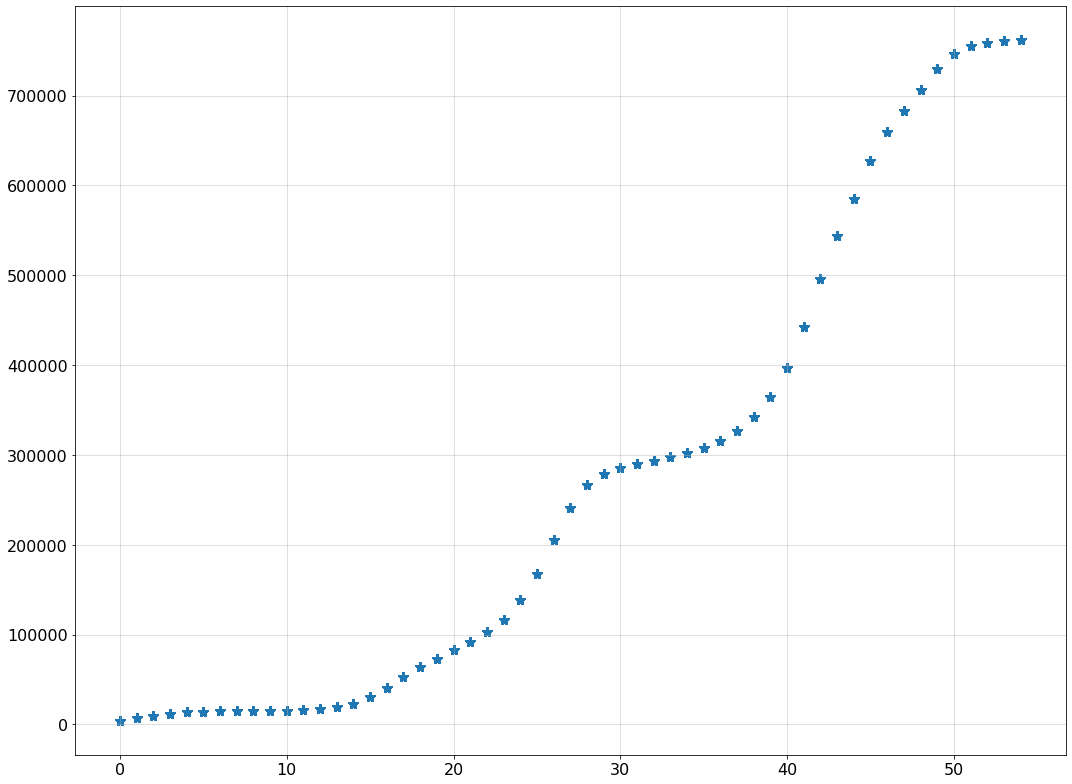

In [74]:
plt.scatter(geo_stats.weeks_from, geo_stats.accumulated_cases_country, marker='*')
plt.grid()

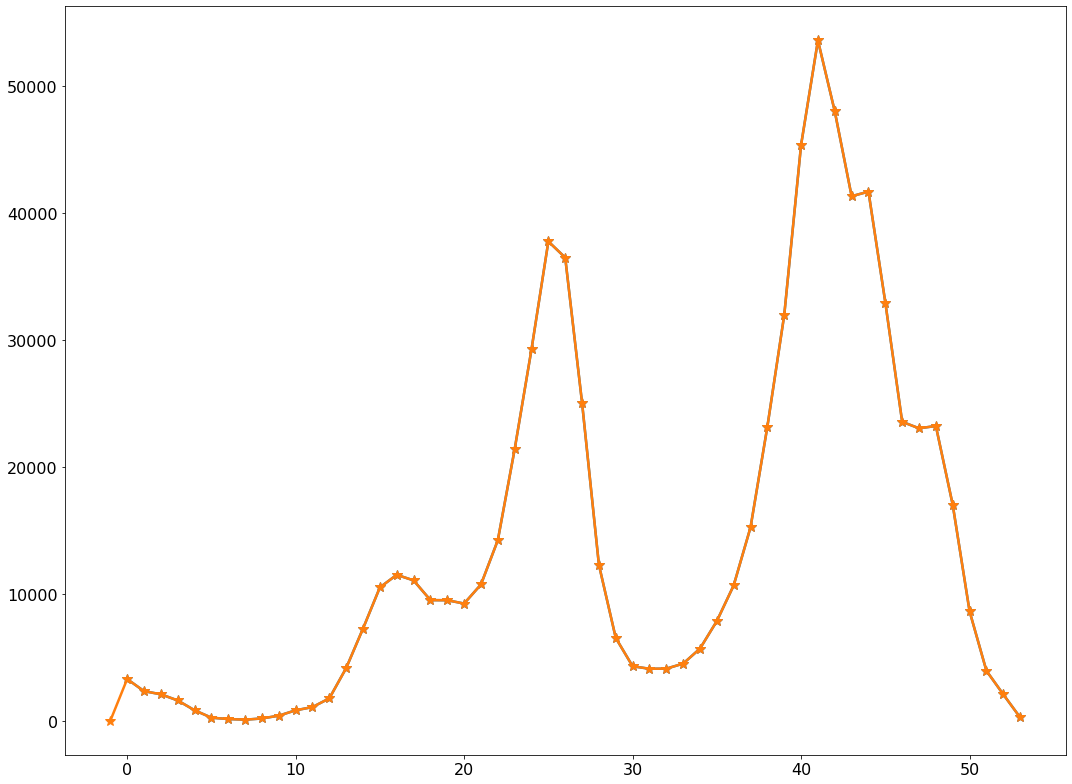

In [75]:
plt.plot(range(np.diff(geo_stats.accumulated_cases_country.unique()).size), np.diff(geo_stats.accumulated_cases_country.unique()), marker='*')
plt.plot(geo_stats.weeks_from.unique()-1, geo_stats.new_cases_on_date_country.unique(), marker='*')